# Correlation for a single GRB

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import networkx as nx

import popsynth
from popsynth.aux_samplers.trunc_normal_aux_sampler import TruncatedNormalAuxSampler
from popsynth.aux_samplers.lognormal_aux_sampler import LogNormalAuxSampler
from aux_samplers import TDecaySampler, DurationSampler, LumSampler, EpeakObsSampler

import cosmogrb

/Users/fran/.virtualenvs/grb/lib/python3.7/site-packages/popsynth/distribution.py:8: TqdmExperimentalWarning: Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
  from tqdm.autonotebook import tqdm as progress_bar


You do not have threeML installed


In [2]:
import logging
logger = logging.getLogger("cosmogrb.grb.gbmgrb")
logger.setLevel(logging.DEBUG)
ch = logging.StreamHandler()
ch.setLevel(logging.DEBUG)
#logger.addHandler(ch)

## Simulate one GRB

In [3]:
pop_gen = popsynth.populations.ParetoSFRPopulation(r0=1./20, rise=1., decay=4.0,
                                                   peak=1.5, Lmin=1e51, alpha=1.5,
                                                   r_max=7.0)

trise = TruncatedNormalAuxSampler(name="trise", observed=False)
trise.lower=0.01
trise.upper=5.0
trise.mu=1
trise.tau=1.0

t90 = LogNormalAuxSampler(name="log_t90", observed=False)
t90.mu=10
t90.tau=0.25

log_ep = LogNormalAuxSampler(name="log_ep", observed=False)
log_ep.mu=300
log_ep.tau=0.4

alpha = TruncatedNormalAuxSampler(name="alpha", observed=False)
alpha.lower=-1.5
alpha.upper=0.1
alpha.mu=1
alpha.tau=0.25

tau = TruncatedNormalAuxSampler(name="tau", observed=False)
tau.lower=1.5
tau.upper=2.5
tau.mu=2
tau.tau=0.25

tdecay = TDecaySampler()
duration = DurationSampler()
luminosity = LumSampler()
log_ep_obs = EpeakObsSampler()

tdecay.set_secondary_sampler(t90)
tdecay.set_secondary_sampler(trise)
duration.set_secondary_sampler(t90)
luminosity.set_secondary_sampler(log_ep)
log_ep_obs.set_secondary_sampler(log_ep)

pop_gen.add_observed_quantity(tdecay)
pop_gen.add_observed_quantity(duration)
pop_gen.add_observed_quantity(luminosity)
pop_gen.add_observed_quantity(log_ep_obs)
pop_gen.add_observed_quantity(alpha)
pop_gen.add_observed_quantity(tau)

registering auxilary sampler: tdecay
registering auxilary sampler: duration
registering derived luminosity sampler: luminosity
registering auxilary sampler: log_ep_obs
registering auxilary sampler: alpha
registering auxilary sampler: tau


In [4]:
population = pop_gen.draw_survey(no_selection=True, boundary=1e-2, verbose=False)
population.writeto('data/single_grb.h5')

No Selection! Added back all objects


## Define GRB

In [5]:
from corr_cpl.corr_cpl_source import CorrCPLSourceFunction
from corr_cpl.corr_cpl_grb import GBMGRB_CORR_CPL

In [6]:
grb = GBMGRB_CORR_CPL(
    ra=312.0,
    dec=-62.0,
    z=1.0,
    peak_flux=5e-7,
    alpha=-0.66,
    ep=300.0,
    ep_tau=-1.5,
    Nrest=1e52,
    gamma=1.5,
    duration=30.0,
    T0=0.,
)

grb.info()

,0
name,SynthGRB
z,1
ra,312
dec,-62
duration,30
T0,0


,0
peak_flux,5.000000e-07
alpha,-6.600000e-01
ep_tau,-1.500000e+00
Nrest,1.000000e+52
gamma,1.500000e+00


,0


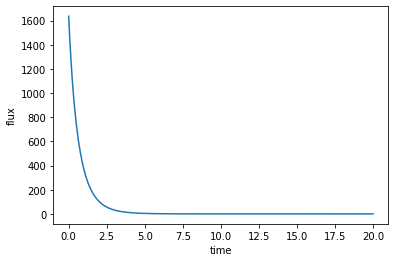

In [10]:
time = np.linspace(0, 20, 500)

grb.display_energy_integrated_light_curve(time);

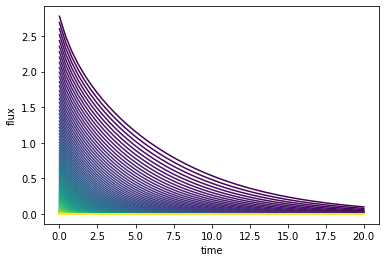

In [28]:
time = np.linspace(0, 20)
energy = np.logspace(1, 3, 100)

grb.display_energy_dependent_light_curve(time, energy, cmap='viridis')

Text(0, 0.5, 'flux')

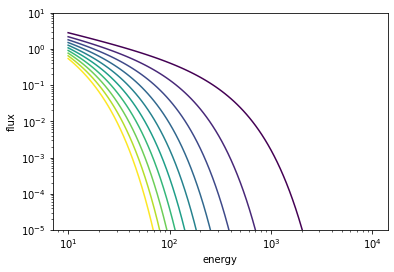

In [30]:
time = np.linspace(0, 10, 10)
energy = np.logspace(1, 4, 100)
out = list(grb._lightcurves.values())[0]._source._source_function.evolution(energy, 
                                                                            time)
fig, ax = plt.subplots()
for y, c in zip(out, plt.cm.viridis(np.linspace(0,1,len(out)))):
    ax.plot(energy, y, color=c)
ax.set_yscale('log')
ax.set_xscale('log')
ax.set_ylim(1e-5, 1e1)
ax.set_xlabel('energy')
ax.set_ylabel('flux')

## Define universe

In [12]:
from cosmogrb.instruments.gbm import GBM_CPL_Universe

In [13]:
universe = GBM_CPL_Universe('data/single_grb.h5', save_path="/data")